# Density of States Analysis Example
* Given sample and empty-can data, compute phonon DOS
* To use this notebook, first click jupyter menu File->Make a copy
* Click the title of the copied jupyter notebook and change it to a new title
* Start executing cells

## Summary of processing steps

* Gather experimental information and experimental raw data
* Reduce raw data to S(Q,E)
* Convert S(Q,E) to DOS

## Preparation

Create a new working directory and change into it.

Please modify the following path to suit your need!

In [1]:
workdir = '/SNS/users/lj7/reduction/ARCS/nano-Si-LiChen/'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/reduction/ARCS/nano-Si-LiChen


Get tools ready

In [2]:
import os, numpy as np
import histogram.hdf as hh, histogram as H
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline

from multiphonon.sqe import plot as plot_sqe
from multiphonon.ui.getdos import Context, NxsWizardStart, QEGridWizardStart, GetDOSWizStart

Create a context for getdos

In [3]:
context=Context()

If you want to reuse a previously-saved context, please uncomment the following cell and execute

In [5]:
context.from_yaml('./getdos2-fixing-DW-context.yaml')

## Experimental data and condition

Phonon Density of States (DOS) can be obtained from inelastic neutron scattering (INS) spectrum.
This notebook allows for extracting DOS from INS spectrum measured at the ARCS instrument at SNS.
To start, we need data files measured for the sample and the empty can, as well as experimental conditions such as incident energy and sample temperature.
The following wizard help you go through these steps.

<img src="getdos2-select_raw_data.png" width="500"/>

Example datasets:

* samplenxs = "/SNS/ARCS/IPTS-18718/shared/chen/reduction/Si_4nm_90meV/Si_4nm_90meV_run_number_99155_13p32.nxspe"
* mtnxs = Skip
* Ei=90
* T=300

In [7]:
cat /SNS/ARCS/IPTS-18718/0/99155/preNeXus/ARCS_99155_runinfo.xml

<?xml version="1.0"?>
<RunInfo instrument="ARCS" runnumber="99155" experiment="0" version="4.3" xmlns="http://neutrons.ornl.gov/SNS/DAS/runinfo_v4_3">
<DateTime>
	<StartTime> 2017-08-24T22:02:55-05:00 </StartTime>
	<StopTime> 2017-08-24T23:25:08-05:00 </StopTime>
	<LastUpdate> 2017-08-24T23:25:08-05:00 </LastUpdate>
</DateTime>
<OperationalInfo>
		<AcceleratorPulses> 295989 </AcceleratorPulses>
		<PCurrent units="pC"> 4.301924e+012 </PCurrent>
		<TotalVetos>0</TotalVetos></OperationalInfo>
<SampleInfo Name="Silicon nanocrystal" Identifier="41415">
	<Nature> NONE </Nature>
</SampleInfo>
<GeneralInfo>
	<Title>99155 4nm Si 3/8inch Al can 5K Ch2 90meV 480Hz T0 90Hz </Title>
	<Notes>no notes</Notes>
	<SpecialDesignation></SpecialDesignation>
	<ScriptID>none</ScriptID>
	<RunStatus>Stopped</RunStatus>
	<ExpTitle>No title entered</ExpTitle>
</GeneralInfo>
<DetectorInfo id="180001000">
	<CalibrationID> 105 </CalibrationID>
	<MaxScatPixelID> 117760 </MaxScatPixelID> 
	<MaxBMPixelID> 268435457 </

In [6]:
NxsWizardStart(context).show()

HTML(value=u'Please wait...')

HTML(value=u'Please wait...')

Done.


Save configuration so you can reuse it

In [8]:
context.to_yaml('./getdos2-fixing-DW-context.yaml')

## Obtain S(Q,E)

S(Q,E) spectra for both the sample and the empty can is the starting point for getdos processing. Here is an example:

<img width="300" src="Al-SQE.png"/>

Run the following wizard to define the E and Q axes so that S(Q,E) spectra can be obtained the INS raw data.

In [6]:
QEGridWizardStart(context).show()

/SNS/software/miniconda2/envs/spida/lib/python2.7/site-packages/multiphonon-0.1.2a2-py2.7.egg/multiphonon/getdos.py:184: UserWarning: Zero has to be one of the ticks in the energy axis.
Energy axis modified from (-85.5, 85.5001, 1.0) to (-85.0, 85.0, 1.0) 

  "Energy axis modified from %s to %s \n" % (saved, new)


Converting sample data to powder I(Q,E)...
* Checking Mantid ...
  - Done.
Results: sample IQE, MT IQE, Qaxis, Eaxis
('/SNS/users/lj7/reduction/ARCS/nano-Si-LiChen/work/iqe.h5', None, (0.0, 15.00001, 0.1), (-85.0, 85.0, 1.0))
Done.


Parameters are saved in the work dir. Uncomment the script below to see.

In [ ]:
%%script bash
# ls work/
# cat work/raw2iqe-sample.params

Plot sample IQE

In [9]:
iqe = hh.load('work/iqe.h5')

/SNS/software/miniconda2/envs/spida/lib/python2.7/site-packages/histogram/hdf/Loader.py:129: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'storage' in list(dataGroup): # this uses the 'storage' convention


In [ ]:
plt.figure(figsize=(6,4))
plot_sqe(iqe)
# plt.xlim(0, 11)
plt.clim(0, 200)

Adjust DW factor

In [11]:
cp work/iqe.h5 work/iqe-saved.h5

In [21]:
iqe = hh.load('work/iqe.h5')

In [22]:
B = 0.019883456711439741 - 0.0015574731305256428
iqe.I *= np.exp(B*iqe.Q*iqe.Q)[:, np.newaxis]

<IPython.core.display.Javascript object>


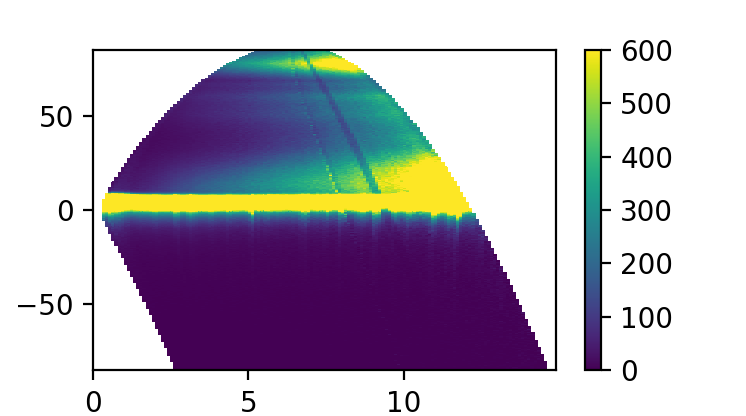

In [24]:
plt.figure(figsize=(6,4))
plot_sqe(iqe)
# plt.xlim(0, 11)
plt.clim(0, 600)

In [36]:
hh.dump(iqe, 'work/iqe.h5')

Plot I(E)

<IPython.core.display.Javascript object>


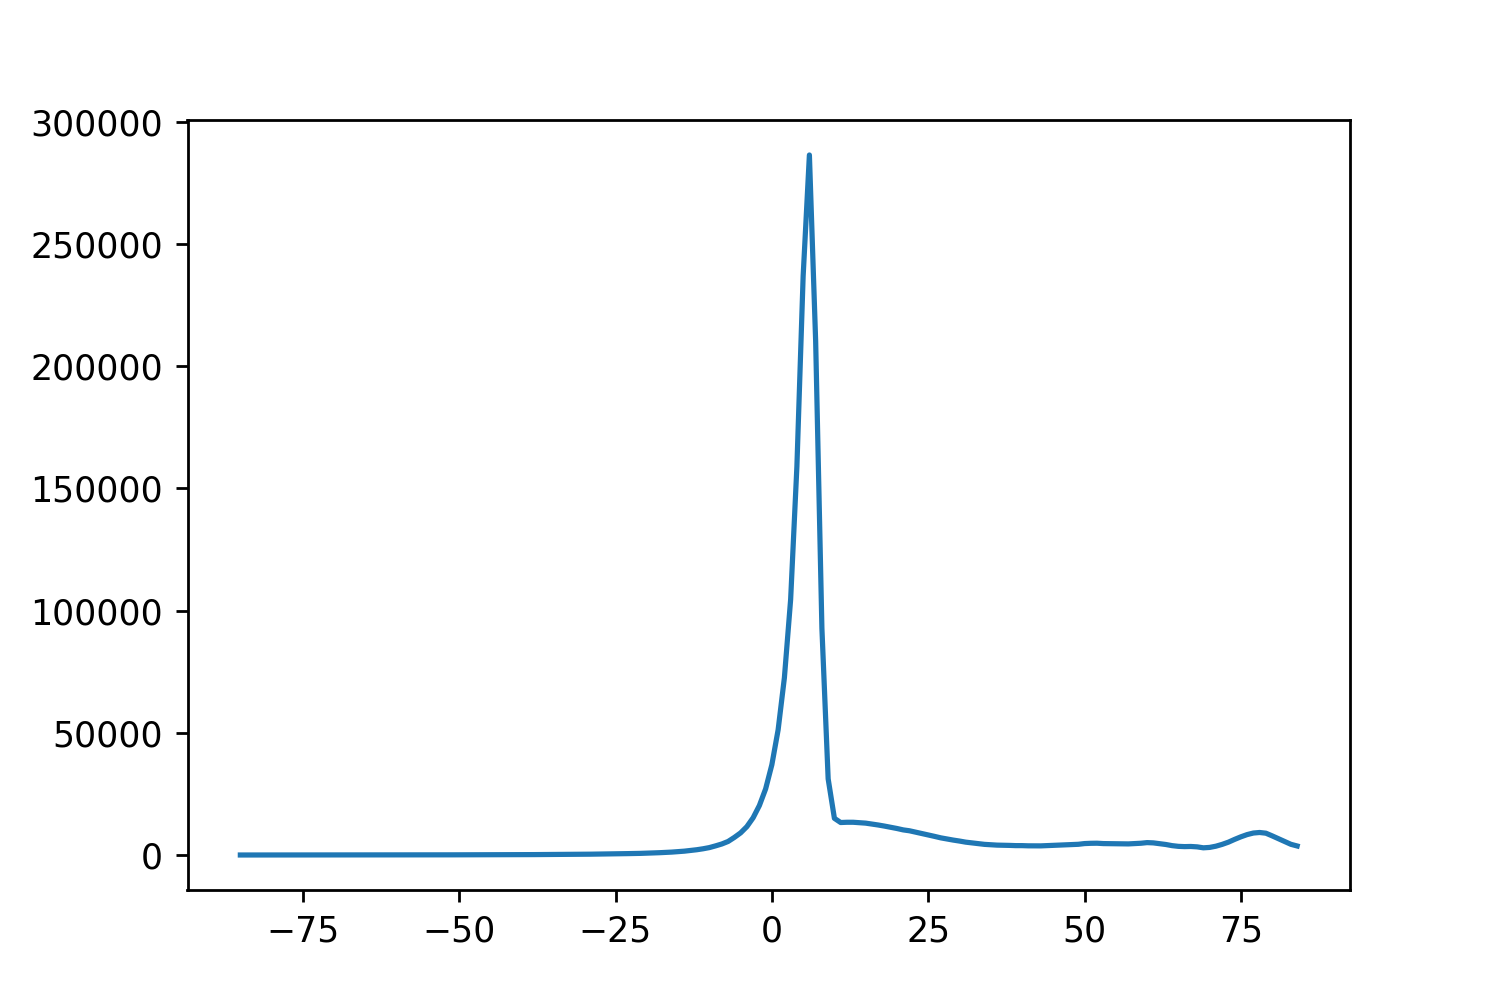

In [14]:
iqe2 = iqe.copy()
I = iqe2.I; I[I!=I] = 0 # remove NaNs
IE = iqe2.sum('Q')  # sum over Q
plt.figure(figsize=(6,4))
plt.plot(IE.E, IE.I)

The plots above provide clues to selecting parameters for the getdos procedure

Save configuration so you can reuse it

In [15]:
context.to_yaml('./getdos2-context.yaml')

## Run GetDOS

DOS will be obtained from SQE by an iterative procedure where multiphonon and multiple scattering corrections are applied to the measured SQE spectrum, assuming
incoherent approximation, and the corrected spectrum
is then converted to DOS.

An example DOS plot:
<img width="300" src="Al-DOS.png"/>

In [41]:
GetDOSWizStart(context).show()

HTML(value=u'Please wait...')

Save context

In [43]:
context.to_yaml('./getdos2-context.yaml')

Print context

In [42]:
print context

ElasticPeakMax=10.0
update_strategy_weights=(0.5, 0.5)
initdos=None
mt_nxs=None
Qmin=0.0
maxiter=10
const_bg_fraction=0.0
sample_nxs=/SNS/ARCS/IPTS-18718/shared/chen/reduction/Si_4nm_90meV/Si_4nm_90meV_run_number_99155_13p32.nxspe
workdir=work
Emin=-85.5
Eaxis=(-85.0, 85.0, 1.0)
M=28.0
Qmax=15.0
mtiqe_h5=None
iqe_h5=/SNS/users/lj7/reduction/ARCS/nano-Si-LiChen/work/iqe.h5
Ecutoff=85.0
Ei=90.0
T=5
Emax=85.5
dE=1.0
ElasticPeakMin=-20.0
mt_fraction=0.9
C_ms=0.1
Qaxis=(0.0, 15.00001, 0.1)
dQ=0.1


## Check output

Results are saved in "work" directory

In [28]:
ls work/

dirdydos/          iqe.h5                  plot_residual.py*      round-1/
final-dos.h5       iqe.h5.bkup-wrongEaxis  raw2iqe-sample.params  round-2/
getdos-kargs.yaml  iqe-saved.h5            residual_E-posE.h5
I_E-exp-posE.h5    plot_dos_iteration.py*  round-0/


Plot the final result for DOS

<IPython.core.display.Javascript object>


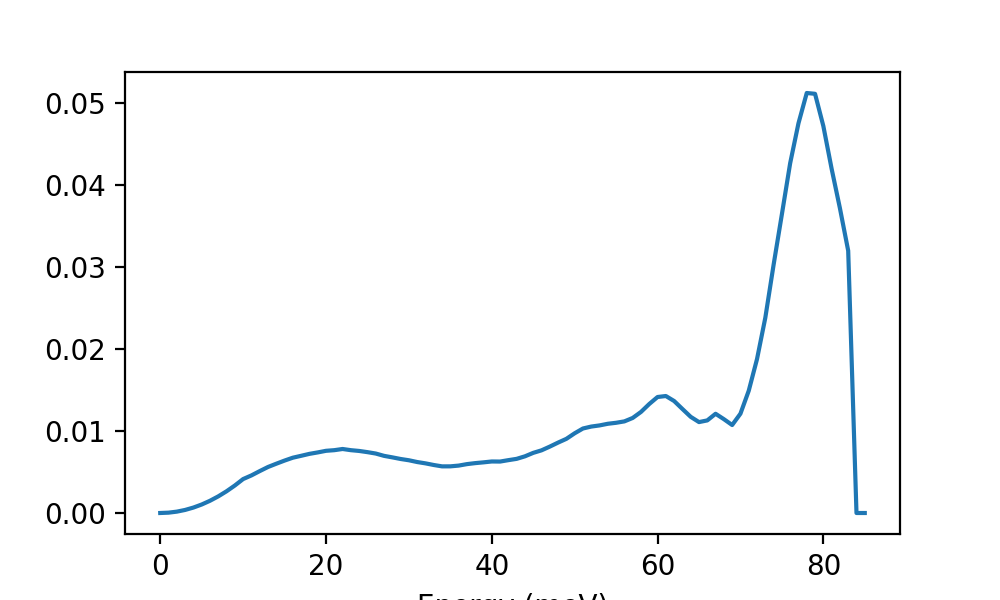

In [44]:
dos = hh.load('work/final-dos.h5')
plt.figure(figsize=(5,3))
plt.plot(dos.E, dos.I)
plt.xlabel('Energy (meV)')
# plt.xlim(0, 30)

More plotting utils are available

In [30]:
from multiphonon.backward import plotutils as pu

<IPython.core.display.Javascript object>


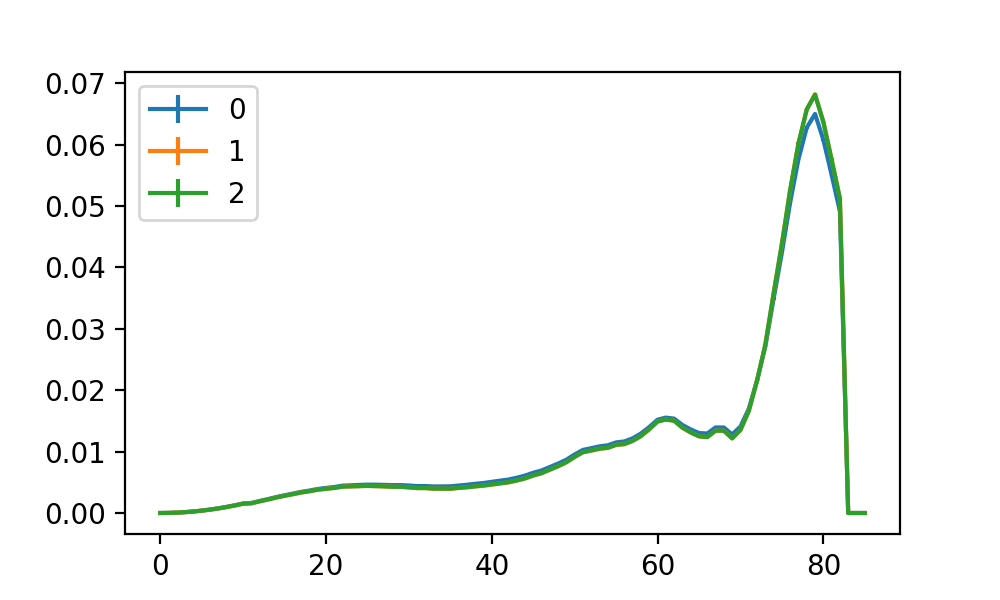

In [31]:
plt.figure(figsize=(5,3))
pu.plot_dos_iteration('work/')

In [ ]:
plt.figure(figsize=(6,4))
pu.plot_residual('work/')

In [ ]:
plt.figure(figsize=(10, 4))
pu.plot_intermediate_result_se('work/round-2')

<IPython.core.display.Javascript object>


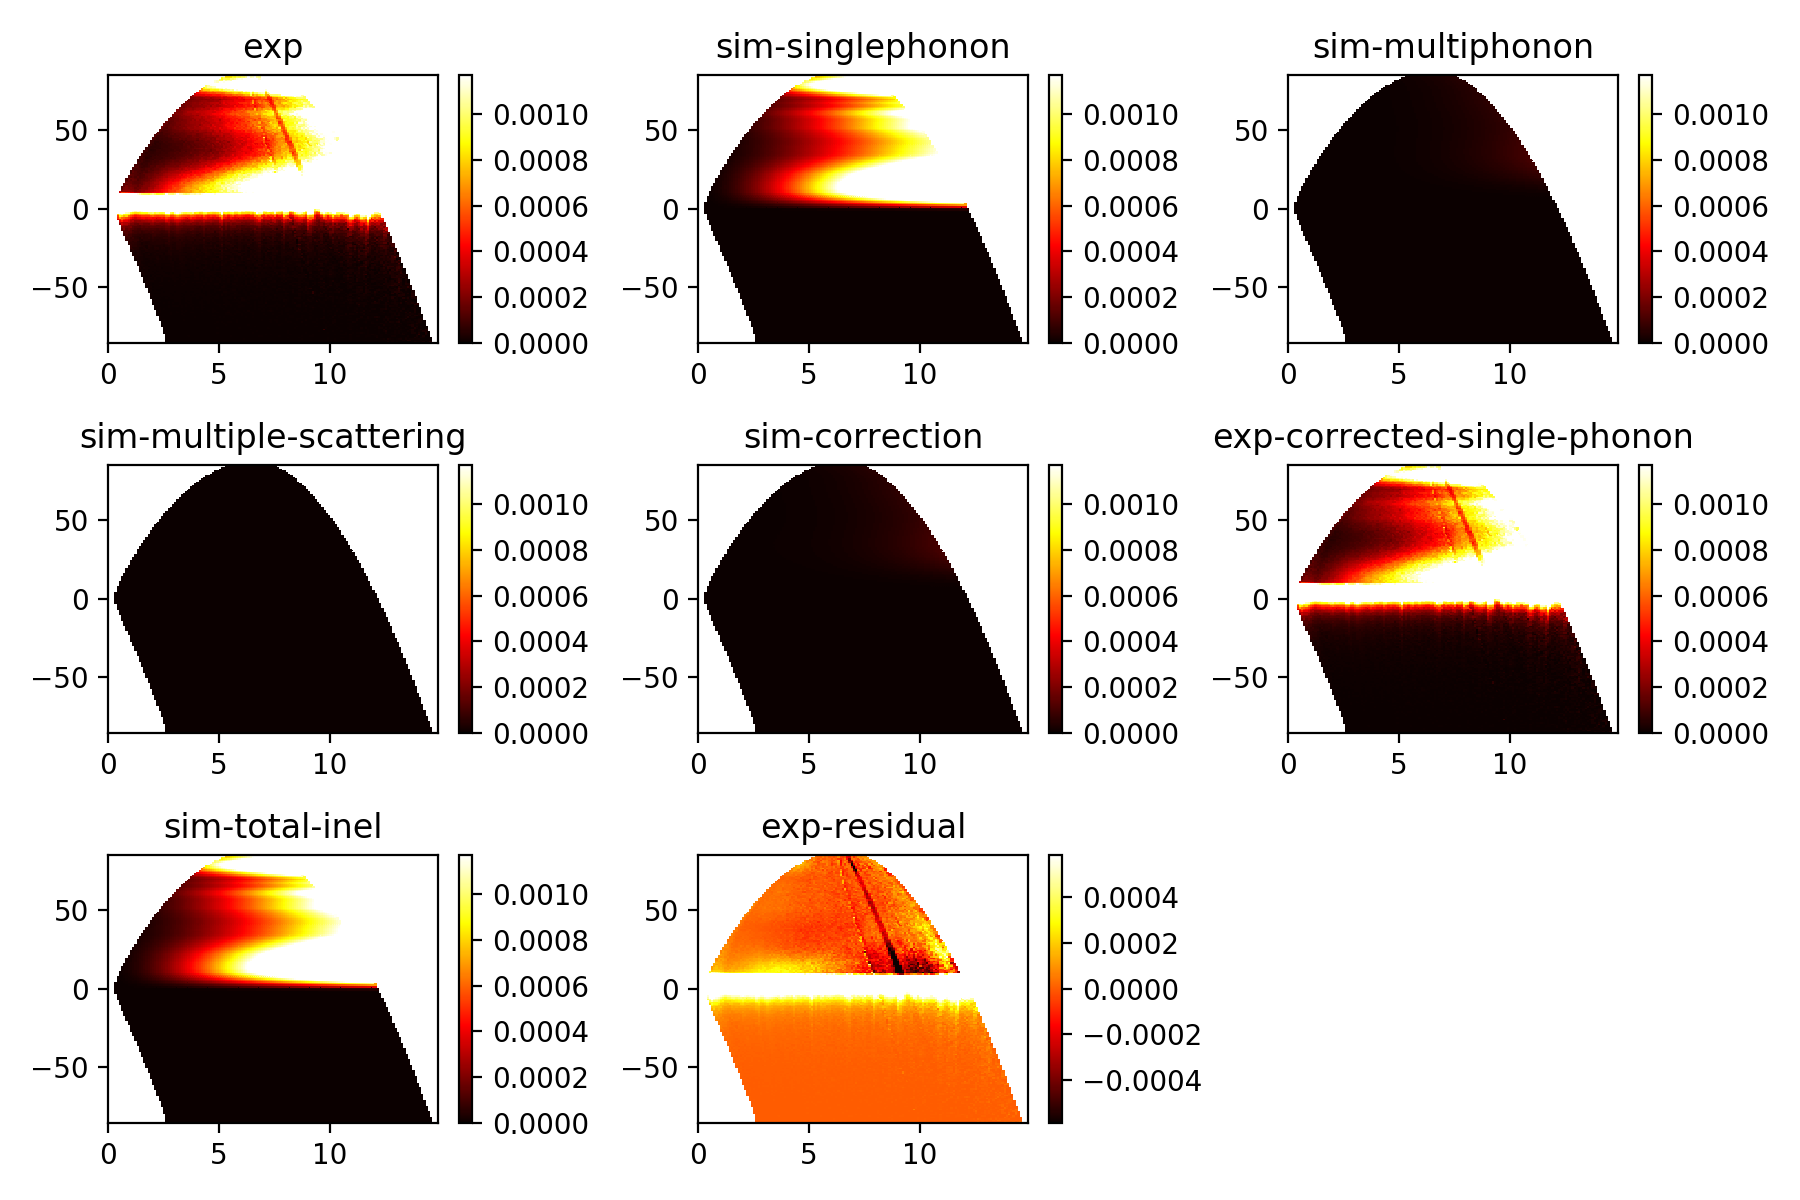

In [45]:
plt.figure(figsize=(9, 6))
pu.plot_intermediate_result_sqe('work/round-2')